# CorrSeg

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# sklearn
from sklearn.impute import SimpleImputer

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
from torchsummary import summary
from torchvision.transforms import v2
from torchmetrics import JaccardIndex

### Loading data

                  0  1  2  3  4  5  6  7  8  9  ...  1286  1287  1288  1289  \
well_10_patch_0   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_1   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_10  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_11  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_10_patch_12  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
...              .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   
well_15_patch_95  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_96  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_97  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_98  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   
well_15_patch_99  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0   

                  1290  1291  1292  1293  1294  129

<Axes: >

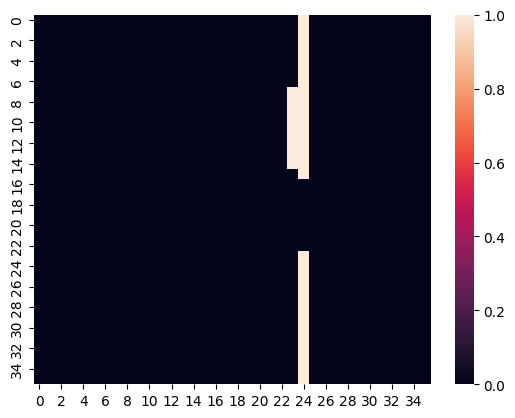

In [11]:
# Read file
y_train = pd.read_csv('../y_train_PlZf4rH.csv', index_col=0) #Table with index being the name of the patch
print(y_train)
y_1_130 = np.array(y_train.loc['well_1_patch_130'])

# Access to one patch label
sns.heatmap(np.array(y_train.loc['well_1_patch_40']).reshape(36, 36))

In [20]:
path = Path('./images_data.npy')
if path.exists():
    images_array = np.load(path)
    with open('image_names.txt', 'r') as f:
        image_names = f.read().splitlines()
else:
    # Initialize paths
    path = Path('../images')
    image_paths = list(path.iterdir())  # Use list directly

    # Function to load an individual image
    def load_image(path):
        return np.load(path)

    # Use ThreadPoolExecutor for parallel file loading
    n = len(image_paths)
    images_array = np.empty((n, 36, 36), dtype=np.float32)
    image_names = [p.stem for p in image_paths]  # Store the names of patches
    with ThreadPoolExecutor() as executor:
        loaded_images = list(tqdm(executor.map(load_image, image_paths), total=n))

    images_array[:] = loaded_images  # Assign loaded images
    np.save('images_data.npy', images_array)
    with open('image_names.txt', 'w') as f:
        for name in image_names:
            f.write(f"{name}\n")

In [21]:
labels = y_train.reindex(image_names)

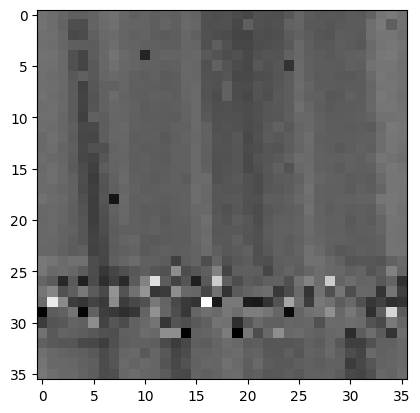

In [22]:
plt.imshow(images_array[9] * 255, cmap='gray')

In [23]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## EDA

In [24]:
def plot_mask_and_image(img, label):    
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    print(type(x))
    print(x.shape)

    sns.heatmap(label, ax=axes[0])
    axes[0].set_title('Heatmap')
    axes[0].set_aspect('equal')

    axes[1].imshow(img, cmap='gray')
    axes[1].set_title('Image')

    plt.tight_layout()

In [25]:
def plot_mask_and_image_and_pred(img, label, pred):    
    _, axes = plt.subplots(1, 3, figsize=(13, 5))

    print(type(x))
    print(x.shape)

    sns.heatmap(label, ax=axes[0])
    axes[0].set_title('Heatmap of label')
    axes[0].set_aspect('equal')

    axes[1].imshow(img, cmap='gray')
    axes[1].set_title('Image')

    sns.heatmap(pred.squeeze(0).squeeze(0).detach().numpy(), ax=axes[2])
    axes[2].set_title('Heatmap of prediction')
    axes[2].set_aspect('equal')

    plt.tight_layout()

In [26]:
def plot_two_images(x1, x2):

    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    print(np.unique(x1))

    axes[0].imshow(x1, cmap='gray')
    axes[0].set_title('Image OG')
    axes[0].set_aspect('equal')

    axes[1].imshow(x2, cmap='gray')
    axes[1].set_title('Image Flip')
    axes[0].set_aspect('equal')

    plt.tight_layout()

In [27]:
print(np.unique(images_array))
# np.equal(images, nan)
np.argwhere(images_array == np.nan)

[-9.9925000e+02 -9.9900000e+02 -9.3992406e-01 ...  4.2167890e-01
  4.7034341e-01            nan]


array([], shape=(0, 3), dtype=int64)

In [28]:
np.min(images_array)

np.float32(nan)

## Preprocessing

In [29]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
images_array_imp = imputer.fit_transform(images_array.reshape(n, 36*36)).reshape(n, 36, 36)

In [30]:
labels = y_train.reindex(image_names)
flip_amount = len(labels) # 4000

In [31]:
in_img = torch.tensor(images_array_imp[:flip_amount], dtype=torch.float32, device=mps_device)
in_labels = torch.tensor(labels[:flip_amount].values.reshape(-1, 36, 36), dtype=torch.float32, device=mps_device)

#### Horizontal Flip

In [32]:
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=1),
])

out_img = transform(in_img)
out_labels = transform(in_labels)

print(out_img.shape)
print(out_labels.shape)

img_aug = torch.concat([in_img, out_img], 0)
labels_aug = torch.concat([in_labels, out_labels], 0)
img_aug.shape

torch.Size([9674, 36, 36])
torch.Size([9674, 36, 36])


torch.Size([19348, 36, 36])

#### Vertical Flip

In [33]:
transform = v2.Compose([
    v2.RandomVerticalFlip(p=1),
])
flip_amount = len(labels) # 4000
out_img = transform(in_img).to(mps_device)
out_labels = transform(in_labels).to(mps_device)

print(out_img.shape)
print(out_labels.shape)

img_aug = torch.concat([img_aug, out_img], 0)
labels_aug = torch.concat([labels_aug, out_labels], 0)

img_aug.shape
labels_aug.shape

torch.Size([9674, 36, 36])
torch.Size([9674, 36, 36])


torch.Size([29022, 36, 36])

[-0.04917306 -0.047216   -0.04526222 ...  0.02709413  0.02773702
  0.03081495]


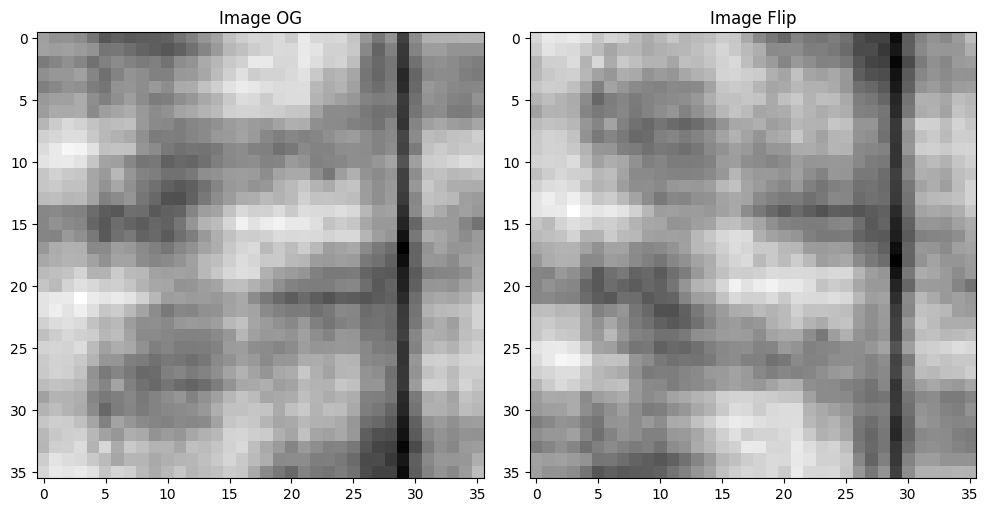

In [34]:
in_img[0]
id = 486

plot_two_images(in_img[id].cpu(), out_img[id].cpu())

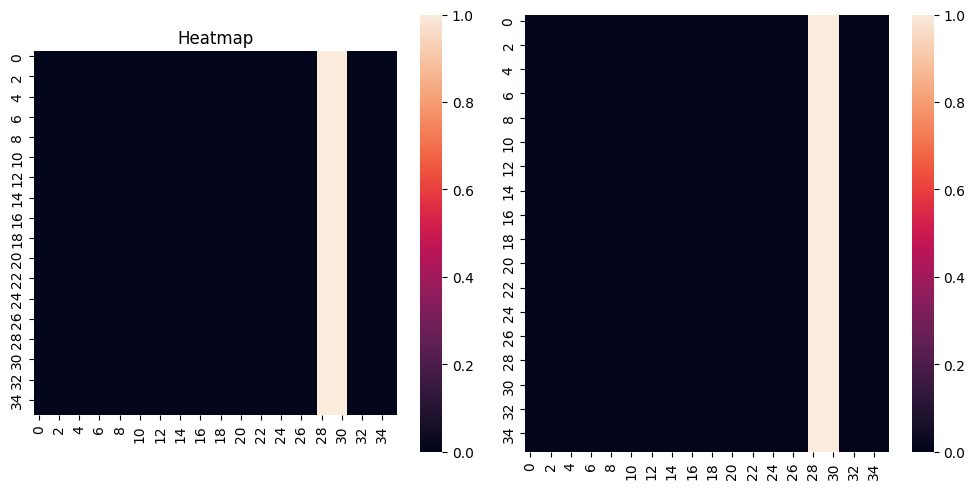

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(np.array(in_labels[id].cpu()).reshape(36, 36), ax=axes[0])
axes[0].set_title('Heatmap')
axes[0].set_aspect('equal')

sns.heatmap(np.array(out_labels[id].cpu()).reshape(36, 36), ax=axes[1])
axes[0].set_title('Heatmap')
axes[0].set_aspect('equal')

plt.tight_layout()

### Data augmentation

In [36]:
torch.manual_seed(12)  # For reproducibility
indices = torch.randperm(len(labels))
print(indices[:10])

tensor([6781, 5987, 8880, 1142, 3557,  805, 4077, 2260, 1980, 7639])


In [37]:
torch.manual_seed(12)
print(np.unique(indices).shape)

(9674,)


In [38]:
indices = torch.randperm(len(img_aug))

img_shuffle = img_aug[indices]
print(indices[:10])
# labels_aug = labels_aug[indices]
labels_shuffle = labels_aug[indices]
id
print(img_aug[indices[485]])
print(img_shuffle[485])

for tens in out_img:
    if tens.max() == 1:
        print(tens)

for tens in img_shuffle:
    if tens.max() == 1:
        print(tens)


tensor([16455, 19006, 15684, 28245, 10883, 17910, 13161, 20425, 15798, 11250])
tensor([[-0.0678, -0.0149, -0.0057,  ..., -0.0021, -0.0031, -0.0082],
        [-0.0481, -0.0116,  0.0010,  ..., -0.0012, -0.0030, -0.0048],
        [-0.0419, -0.0158,  0.0013,  ...,  0.0049,  0.0031, -0.0015],
        ...,
        [ 0.0145,  0.0216,  0.0105,  ...,  0.0076, -0.0532,  0.0013],
        [ 0.0107,  0.0211,  0.0152,  ...,  0.0035, -0.0608, -0.0013],
        [ 0.0129,  0.0205,  0.0142,  ...,  0.0029, -0.0688, -0.0274]],
       device='mps:0')
tensor([[-0.0678, -0.0149, -0.0057,  ..., -0.0021, -0.0031, -0.0082],
        [-0.0481, -0.0116,  0.0010,  ..., -0.0012, -0.0030, -0.0048],
        [-0.0419, -0.0158,  0.0013,  ...,  0.0049,  0.0031, -0.0015],
        ...,
        [ 0.0145,  0.0216,  0.0105,  ...,  0.0076, -0.0532,  0.0013],
        [ 0.0107,  0.0211,  0.0152,  ...,  0.0035, -0.0608, -0.0013],
        [ 0.0129,  0.0205,  0.0142,  ...,  0.0029, -0.0688, -0.0274]],
       device='mps:0')


tensor([-0.0360, -0.0358, -0.0349,  ...,  0.0440,  0.0509,  0.0572],
       device='mps:0')
[-0.03600788 -0.03581595 -0.0349457  ...  0.04396585  0.05088395
  0.05720514]


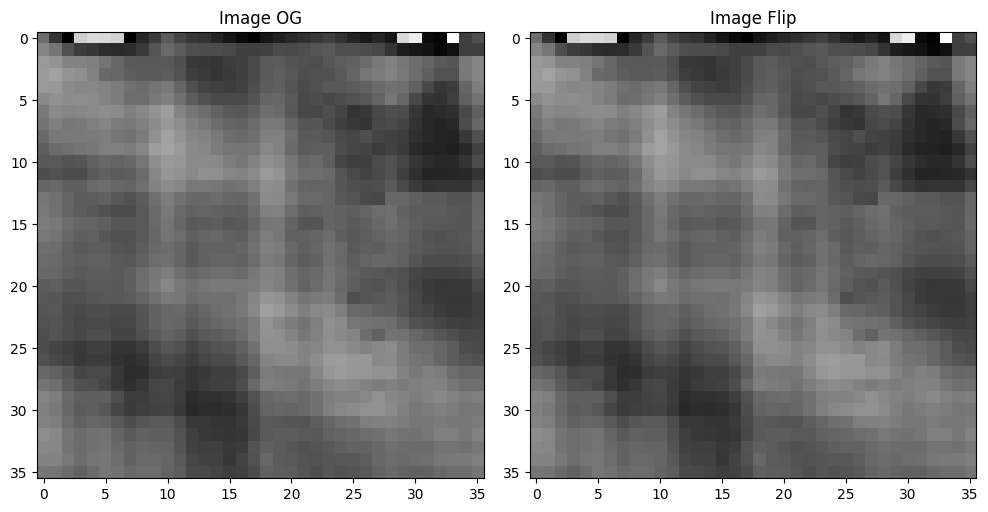

In [39]:
id = 1965
print(img_aug[indices[id]].unique())
plot_two_images(img_aug[indices[id]].cpu(), img_shuffle[id].cpu())

<class 'torch.Tensor'>
torch.Size([1])


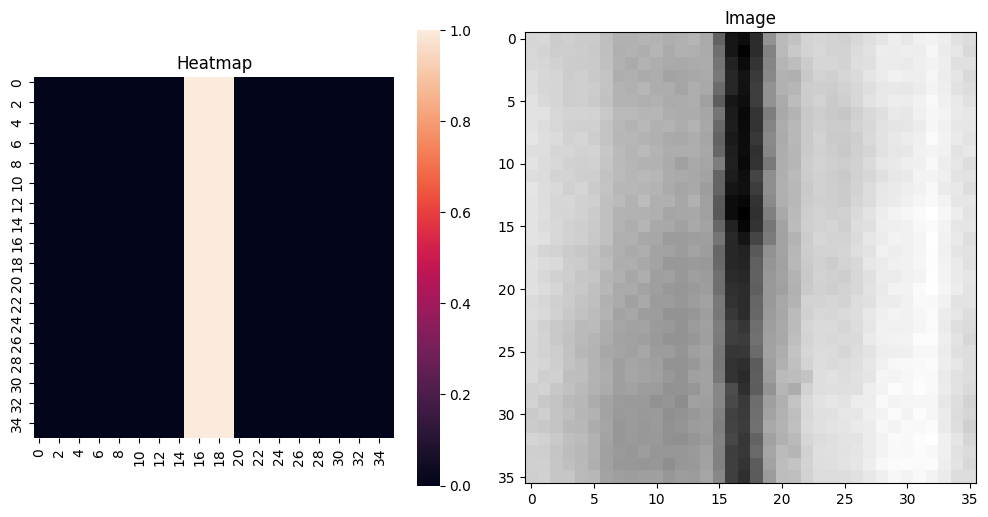

In [40]:
id = 1951
plot_mask_and_image(img_shuffle[id].cpu(), labels_shuffle[id].cpu())

In [41]:
cutoff = int(len(img_shuffle) * 0.8)
train_set = torch.utils.data.TensorDataset(
    img_shuffle[:cutoff], 
    labels_shuffle[:cutoff])
val_set = torch.utils.data.TensorDataset(
    img_shuffle[cutoff:], 
    labels_shuffle[cutoff:])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)

## CNN

In [42]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )

        for layer in self.conv:
            if isinstance(layer, nn.Conv2d):
                init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self, X):
        return self.conv(X)

In [43]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, padding=0, pad=False) -> None:
        super().__init__()

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(
                in_ch, out_ch, 
                kernel_size=2, 
                stride=stride,
                padding=padding,
                bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_ch, out_ch, 
                kernel_size=3, 
                stride=1, 
                padding=1,
                bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_ch, out_ch, 
                kernel_size=3, 
                stride=1, 
                padding=1, 
                bias=False),
            nn.ReLU(inplace=True),
        )
    def forward(self, X):
        return self.deconv(X)

In [44]:
class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
        init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
                

    def forward(self, X):
        return self.conv(X)


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Encoding
        self.in_conv = (Down(1, 32))
        self.conv1 = (Down(32, 32, stride=2)) # double the pixels
        self.conv11 = (Down(32, 64, stride=1)) # compress the channels
        self.conv2 = (Down(64, 64, stride=2)) # double the pixels

        # Decoding
        self.deconv1 = (Up(64, 64, stride=2)) # halve the dimensions (sort of "max pooling")
        self.deconv11 = (Up(128, 32, stride=2)) # compress channels and the dimensions
        self.out_conv = (OutConv(64, 1))



    def forward(self, x):
        # Encoder
        x0 = self.in_conv(x) # 1 -> 32
        x1 = self.conv1(x0) # 32 -> 32
        x11 = self.conv11(x1)
        x2 = self.conv2(x11) # 32 -> 64

 
        # Decoder
        x = self.deconv1(x2) # 64 -> 32
        x = self.deconv11(torch.cat([x11, x], 1)) #64 -> 32; skip connection

        #output
        x = torch.sigmoid(self.out_conv(torch.cat([x0, x], 1))) # 32 -> 1; skip connection
        
        return x

In [46]:
model = CNN()

In [47]:
summary(model, input_size=(1, 36, 36))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 36, 36]             288
              ReLU-2           [-1, 32, 36, 36]               0
            Conv2d-3           [-1, 32, 36, 36]           9,216
              ReLU-4           [-1, 32, 36, 36]               0
            Conv2d-5           [-1, 32, 36, 36]           9,216
              ReLU-6           [-1, 32, 36, 36]               0
              Down-7           [-1, 32, 36, 36]               0
            Conv2d-8           [-1, 32, 18, 18]           9,216
              ReLU-9           [-1, 32, 18, 18]               0
           Conv2d-10           [-1, 32, 18, 18]           9,216
             ReLU-11           [-1, 32, 18, 18]               0
           Conv2d-12           [-1, 32, 18, 18]           9,216
             ReLU-13           [-1, 32, 18, 18]               0
             Down-14           [-1, 32,

Epoch [1/70], Loss: 0.5386, Val Loss: 0.3865


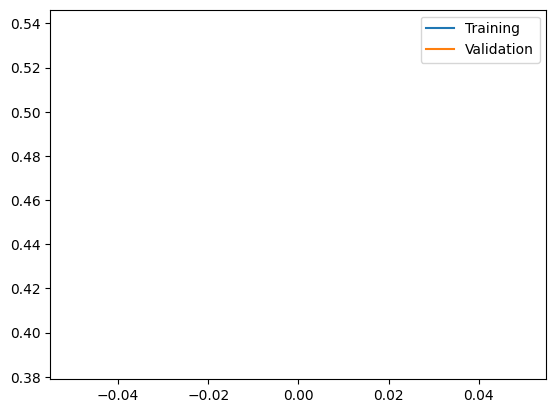

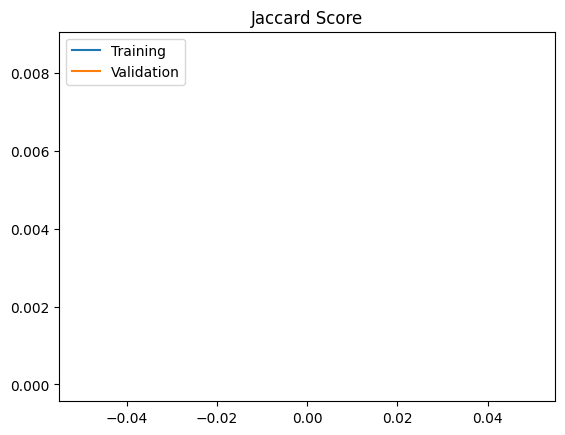

Epoch [2/70], Loss: 0.1663, Val Loss: 0.2559
Epoch [3/70], Loss: 0.1057, Val Loss: 0.2197
Epoch [4/70], Loss: 0.2228, Val Loss: 0.2019
Epoch [5/70], Loss: 0.1055, Val Loss: 0.1919
Epoch [6/70], Loss: 0.1796, Val Loss: 0.1815


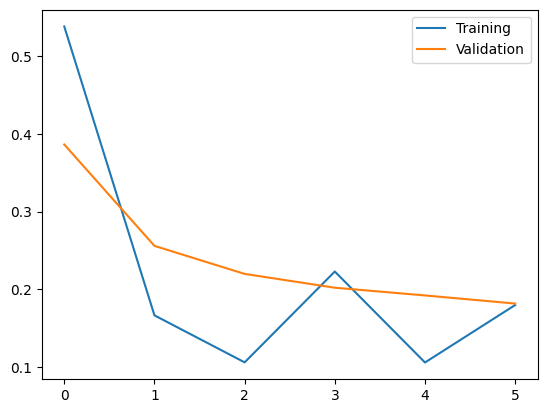

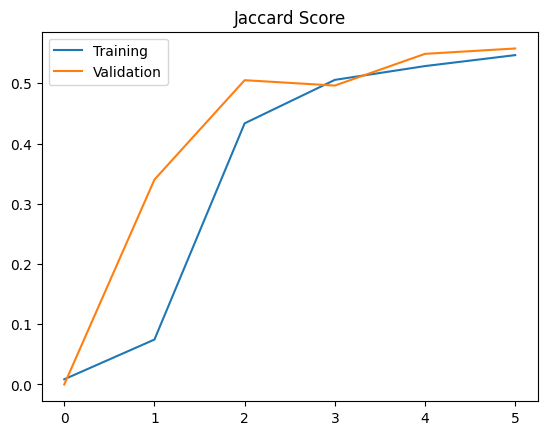

Epoch [7/70], Loss: 0.2297, Val Loss: 0.1747
Epoch [8/70], Loss: 0.2690, Val Loss: 0.1685
Epoch [9/70], Loss: 0.0988, Val Loss: 0.1631
Epoch [10/70], Loss: 0.1728, Val Loss: 0.1610


In [ ]:
# Check if a pre-saved model exists
start = 0
pretrained_model_path = f'./[REPORT]-snapshot_08_mai/trained_model_e_{start}_checkpoint_12_mai_________.pth'
if os.path.exists(pretrained_model_path):
    # Instantiate the model
    model = CNN()
    model.load_state_dict(torch.load(pretrained_model_path))
    model.to(mps_device)
    loss_scores = np.load(f'./loss_scores_{start}.npy')
    val_loss_scores = np.load(f'./val_loss_scores_{start}.npy')
    jacc_scores = np.load(f'./jacc_scores_{start}.npy')
    val_jacc_scores = np.load(f'./val_jacc_scores_{start}.npy')
else:
    # Instantiate a new model
    model = CNN()
    model.to(mps_device)


# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 70
plot_frequency = 5
loss_scores = []
val_loss_scores = []
jacc_scores = []
val_jacc_scores = []
jaccard = JaccardIndex(task='binary').to(mps_device)

# Clean up MPS memory before training
torch.cuda.empty_cache()
torch.mps.empty_cache()

for epoch in range(start, num_epochs):
    model.train()
    jacc_score = 0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images.unsqueeze(1)) # unsqueeze to add a channel dimension
        loss = criterion(outputs, labels.unsqueeze(1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        jacc_score += jaccard(outputs, labels.unsqueeze(1))
        
    # Validation loop
    model.eval()
    val_loss = 0
    val_jacc_score = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1)
            labels = labels.unsqueeze(1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            # Jaccard
            val_jacc_score += jaccard(outputs, labels).cpu()
    
    # jacc_scores.append(jacc_score)
    loss_scores.append(loss.item())
    jacc_scores.append(jacc_score.cpu()/len(train_loader))
    val_loss_scores.append(val_loss/len(val_loader))
    val_jacc_scores.append(val_jacc_score.cpu()/len(val_loader))

    # CHECKPOINT
    if epoch >= 25 and epoch % 25 == 0:
        print("saving model")
        torch.save(model.state_dict(), f'trained_model_e_{epoch}_checkpoint.pth')



    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

    # PLOT
    if epoch % plot_frequency == 0:
        plt.plot(loss_scores)
        plt.plot(val_loss_scores)
        plt.legend(['Training', 'Validation'], loc='upper right')
        plt.show()

        plt.plot(jacc_scores)
        plt.plot(val_jacc_scores)
        plt.title('Jaccard Score')
        plt.legend(['Training', 'Validation'], loc='upper left')
        plt.show()

        # SAVE MODEL
        torch.save(model.state_dict(), f'trained_model_e_{epoch}_[26_01].pth')

    if epoch < 100:
        continue
    # CHECK LOSS DESCENT
    elif np.sum(val_loss_scores[-50:]) > np.sum(val_loss_scores[-100:-50]):
        print(f"checked {np.sum(val_loss_scores[-20:])} with {np.sum(val_loss_scores[-40:-20])}")
        torch.save(
            model.state_dict(), 
            f'./snapshot_07_mai_v3/trained_model_e_{epoch + 22250}_critical.pth')
        

torch.save(model.state_dict(), f'trained_model_e:{epoch}_{time.localtime()}.pth')


if epoch % plot_frequency == 0:
    plt.plot(loss_scores)
    plt.plot(val_loss_scores)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    plt.plot(jacc_scores)
    plt.plot(val_jacc_scores)
    plt.title('Jaccard Score')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()


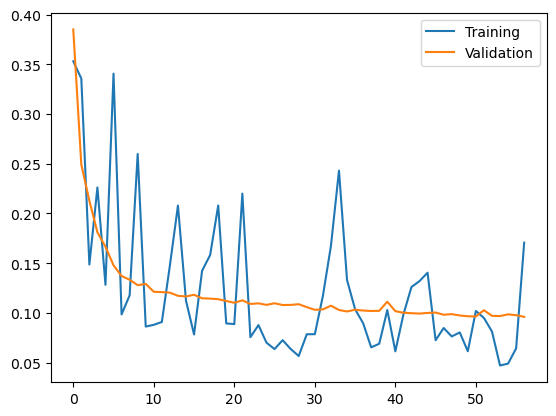

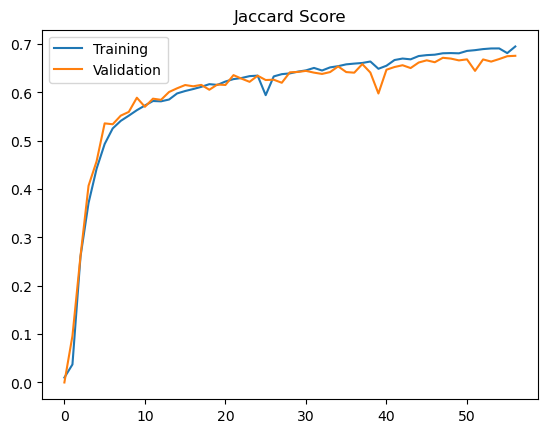

In [93]:
plt.plot(loss_scores)
plt.plot(val_loss_scores)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

plt.plot(jacc_scores)
plt.plot(val_jacc_scores)
plt.title('Jaccard Score')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [78]:
torch.save(model.state_dict(), f'trained_model_e_{epoch}_checkpoint_12_mai.pth')

In [79]:
print(val_loss_scores[-10:])
print(val_loss_scores[-20:-10])

[0.09887337976175806, 0.09747918792392897, 0.09669510145550189, 0.09649263451928677, 0.10278326564508936, 0.09715504749961522, 0.09689570509869119, 0.09864912246880324, 0.0978021809588308, 0.09612078057683032]
[0.10199808296949966, 0.10219383304533751, 0.1113574427107106, 0.10182133316993713, 0.10026074751563695, 0.09979213417872139, 0.09939944322990335, 0.10006011795738469, 0.10043916754100633, 0.09820764997731084]


In [ ]:
np.save(f"loss_scores_{epoch}_12_mai.npy", arr=loss_scores)
np.save(f"val_loss_scores_{epoch}_12_mai.npy", arr=val_loss_scores)
np.save(f"loss_scores_{epoch}_12_mai.npy", arr=loss_scores)
np.save(f"val_loss_scores_{epoch}_12_mai.npy", arr=val_loss_scores)

<class 'torch.Tensor'>
torch.Size([1])


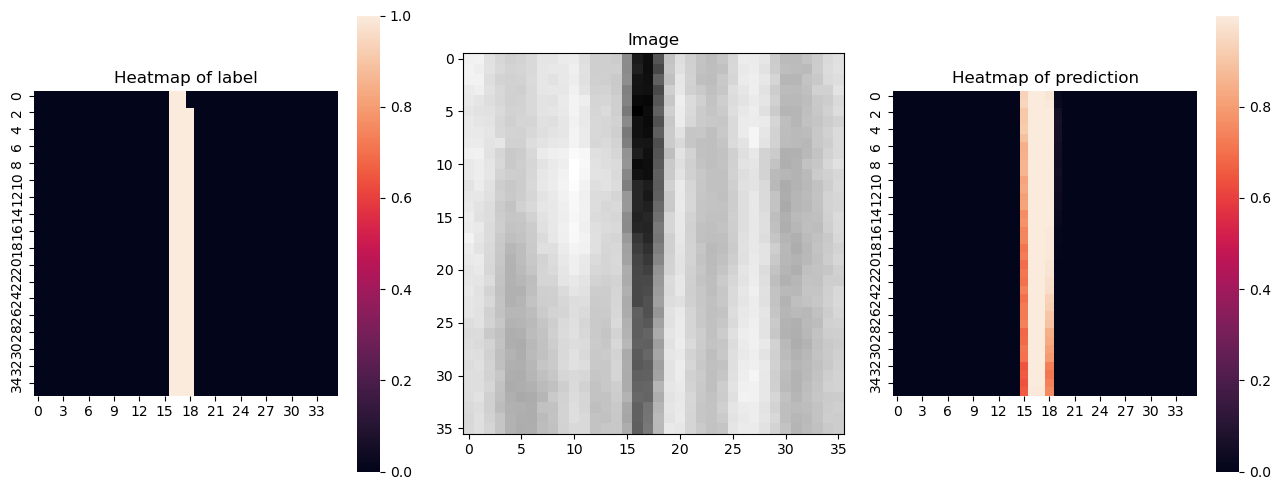

In [81]:
plot_mask_and_image_and_pred(val_set[355][0].cpu(), val_set[355][1].cpu(), model(val_set[355][0].unsqueeze(0).unsqueeze(0)).cpu())


Extracting preditcitions for Challenge Data

In [ ]:
predictions = pd.DataFrame(columns=[str(i) for i in range(1296)])

test_path = Path('../images_test')
model_name = f'./trained_model_e_25_checkpoint.pth' # taking 25th epoch result, looks most apt in terms of IoU
model = CNN()
model.load_state_dict(torch.load(model_name))
model.to(mps_device)
threshold = 0.5

with torch.no_grad():
    for path in test_path.iterdir():
        print(str(path).split('/')[2])
        img = torch.from_numpy(np.load(path)).unsqueeze(0).to(mps_device)
        name = str(path).split('/')[2].split('.')[0]
        pred = model(img.unsqueeze(0))
        pred = np.where(pred.cpu() >= threshold, 1, 0).reshape(-1)
        predictions.loc[name] = pd.Series(pred, index=[str(i) for i in range(1296)])

predictions.to_csv(f'predictions_e_25_{threshold}.csv')
